In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### Data download

In [2]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file(fname="cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

#### Create train and validation dataset

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory=validation_dir, 
                                                                 shuffle=True, 
                                                                 batch_size=BATCH_SIZE, 
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

#### Show the first nine images and labels from the training set:

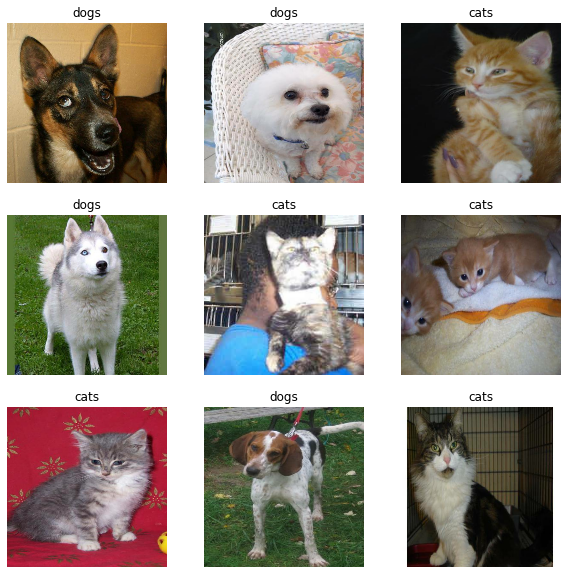

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X=images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Create a test dataset

In [6]:
val_batches = tf.data.experimental.cardinality(dataset=validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

Number of validation batches: 26
Number of test batches: 6


#### Keep the dataset on the ram for configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation for the generalizable model

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

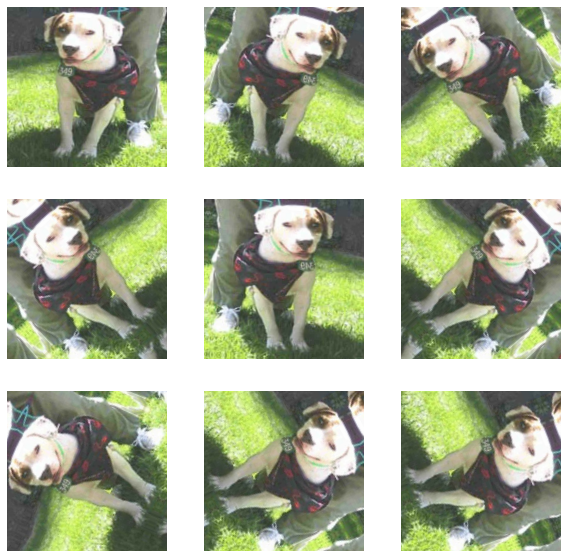

In [10]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(X=augmented_image[0] / 255)
        plt.axis("off")

#### Rescale pixel values

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.src.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
rescale

#### Create the base model from the pre-trained convnets

In [13]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

base_model =tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights="imagenet")

(160, 160)
(160, 160, 3)


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### Freeze the convolutional base

In [15]:
base_model.trainable = False

In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

#### Add a classification head

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


#### Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the "Keras Functional API"

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

In [20]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [22]:
len(model.trainable_variables)

2

#### Train the model

In [23]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

print(f"initial loss: {loss0:.2f}")
print(f"initial accuracy: {accuracy0:.2f}")

26/26 [==============================] - 6s 160ms/step - loss: 0.5782 - accuracy: 0.6510
initial loss: 0.58
initial accuracy: 0.65


In [24]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 16s 231ms/step - loss: 0.2983 - accuracy: 0.8560 - val_loss: 0.0964 - val_accuracy: 0.9629
Epoch 2/10
63/63 [==============================] - 23s 372ms/step - loss: 0.1658 - accuracy: 0.9275 - val_loss: 0.0671 - val_accuracy: 0.9752
Epoch 3/10
63/63 [==============================] - 42s 672ms/step - loss: 0.1436 - accuracy: 0.9360 - val_loss: 0.0601 - val_accuracy: 0.9790
Epoch 4/10
63/63 [==============================] - 44s 686ms/step - loss: 0.1390 - accuracy: 0.9380 - val_loss: 0.0499 - val_accuracy: 0.9851
Epoch 5/10
63/63 [==============================] - 39s 622ms/step - loss: 0.1481 - accuracy: 0.9405 - val_loss: 0.0527 - val_accuracy: 0.9790
Epoch 6/10
63/63 [==============================] - 37s 586ms/step - loss: 0.1162 - accuracy: 0.9530 - val_loss: 0.0508 - val_accuracy: 0.9827
Epoch 7/10
63/63 [==============================] - 40s 638ms/step - loss: 0.1158 - accuracy: 0.9500 - val_loss: 0.0519 - val_accuracy: 0.9777

#### Learning curves

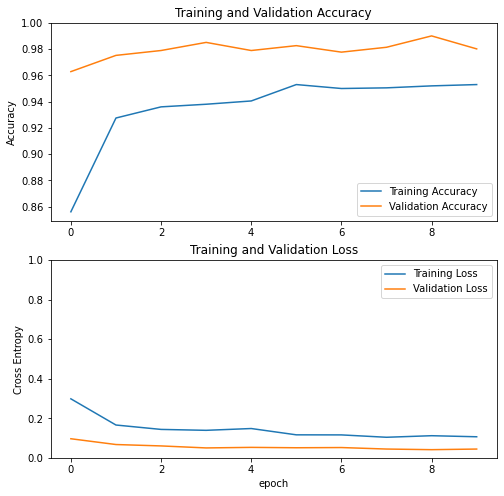

In [27]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show();

#### Un-freeze the top layers of the model

In [28]:
base_model.trainable = True

In [30]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


#### Compile the model

In [31]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=["accuracy"]
)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [33]:
len(model.trainable_variables)

56

#### Continue training the model

In [35]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs = total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data = validation_dataset
)

Epoch 10/20
63/63 [==============================] - 57s 862ms/step - loss: 0.3417 - accuracy: 0.8825 - val_loss: 0.0655 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 27s 418ms/step - loss: 0.1783 - accuracy: 0.9250 - val_loss: 0.0665 - val_accuracy: 0.9728
Epoch 12/20
63/63 [==============================] - 19s 306ms/step - loss: 0.1540 - accuracy: 0.9395 - val_loss: 0.0915 - val_accuracy: 0.9703
Epoch 13/20
63/63 [==============================] - 19s 307ms/step - loss: 0.1228 - accuracy: 0.9580 - val_loss: 0.0631 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 20s 313ms/step - loss: 0.1109 - accuracy: 0.9610 - val_loss: 0.1311 - val_accuracy: 0.9666
Epoch 15/20
63/63 [==============================] - 20s 316ms/step - loss: 0.1067 - accuracy: 0.9590 - val_loss: 0.0471 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 20s 317ms/step - loss: 0.0923 - accuracy: 0.9660 - val_loss: 0.0842 - val_accuracy:

#### Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layer of the MobileNetV2 base model and training the classifier on top of it.

In [36]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

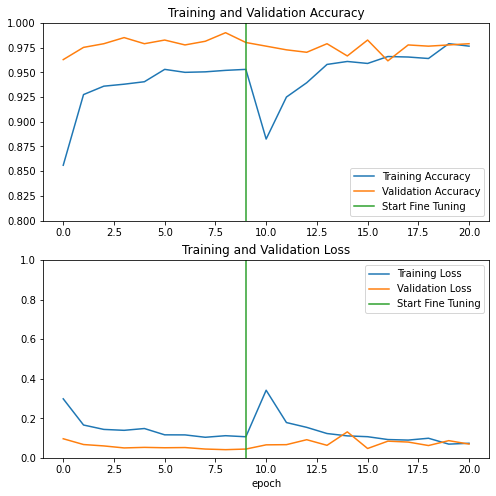

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(),
         label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(),
         label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

#### Evaluation and prediction

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print("Test Accuracy: ", accuracy)

6/6 [==============================] - 1s 152ms/step - loss: 0.0248 - accuracy: 0.9844
Test Accuracy:  0.984375


#### And now we are all set to use this model to predict if our pet is a cat or dog.

Predictions:
 [1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0]
Labels:
 [1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0]


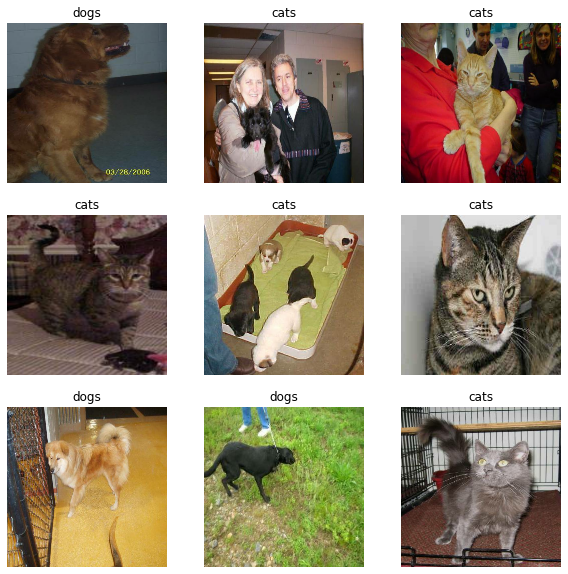

In [43]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [ ]:
?tf.keras.layers.GlobalAveragePooling2D

In [ ]:
?tf.keras.layers.RandomFlip

In [ ]:
?tf.data.experimental.cardinality

In [ ]:
?os.path.join

In [ ]:
?tf.keras.utils.image_dataset_from_directory

In [ ]:
?tf.keras.utils.get_file